# Team 8 : Assignment 4 (Random forest classifier)

## Headers

In [28]:
from sklearn.tree import DecisionTreeClassifier
import sklearn as svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

## Importing CSV

In [29]:
# Importing CSV
# importing dataset from csv file
og_train_data = pd.read_csv("Customer_train.csv")
og_test_data = pd.read_csv("Customer_test.csv")

# printing number of rows in the datasets
print("Number of rows in the training dataset: ", len(og_train_data))
print("Number of rows in the test dataset: ", len(og_test_data))

Number of rows in the training dataset:  1838
Number of rows in the test dataset:  789


## Pre-Processing Training Dataset

In [30]:
# Pre-Processing Training Dataset
def fill_missing_based_on_skewness(df, column):
    if df[column].isnull().sum() > 0:
        skewness = df[column].skew()
        if abs(skewness) > 0.5:
            fill_value = df[column].median()
            method = "median"
        else:
            fill_value = df[column].mean()
            method = "mean"
        df[column].fillna(fill_value, inplace=True)
        print(f"Filled missing '{column}' with {method}: {fill_value}\n")

def transform_if_skewed(df, column):
    if df[column].isnull().sum() == 0:
        skewness = df[column].skew()
        print(f"Skewness of '{column}': {skewness}")
        if abs(skewness) > 0.5:
            df[column] = np.log1p(df[column])
            print(f"Applied log transformation to '{column}' due to skewness.\n")
        else:
            print(f"'{column}' is not significantly skewed; no transformation applied.\n")
    else:
        print(f"Column '{column}' has missing values, handle them before transformation.\n")

def fill_missing_categorical(df, column):
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)
        print(f"Filled missing '{column}' with mode: {mode_value}\n")

# making new df and processing in that one
processed_train_data = og_train_data.copy()

# dropping ID column since no use of it in training classifier
processed_train_data.drop("ID", axis=1, inplace=True)

# calling missing values function on columns as below
fill_missing_based_on_skewness(processed_train_data, "Work_Experience")
fill_missing_based_on_skewness(processed_train_data, "Family_Size")
fill_missing_based_on_skewness(processed_train_data, "Age")

# calling missing values function on categorical columns
fill_missing_categorical(processed_train_data, "Var_1")
fill_missing_categorical(processed_train_data, "Gender")
fill_missing_categorical(processed_train_data, "Ever_Married")
fill_missing_categorical(processed_train_data, "Graduated")
fill_missing_categorical(processed_train_data, "Profession")
fill_missing_categorical(processed_train_data, "Spending_Score")

# calling transformation function on columns as below
transform_if_skewed(processed_train_data, "Work_Experience")
transform_if_skewed(processed_train_data, "Family_Size")
transform_if_skewed(processed_train_data, "Age")

# printing
processed_train_data

Filled missing 'Work_Experience' with median: 1.0

Filled missing 'Family_Size' with median: 2.0

Filled missing 'Var_1' with mode: Cat_6

Filled missing 'Ever_Married' with mode: Yes

Filled missing 'Graduated' with mode: Yes

Filled missing 'Profession' with mode: Artist

Skewness of 'Work_Experience': 1.569560677667064
Applied log transformation to 'Work_Experience' due to skewness.

Skewness of 'Family_Size': 1.0098346177467532
Applied log transformation to 'Family_Size' due to skewness.

Skewness of 'Age': 0.7207833242162786
Applied log transformation to 'Age' due to skewness.



,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Female,No,3.367296,Yes,Artist,2.197225,Low,0.693147,Cat_6,B
1,Male,Yes,3.850148,Yes,Entertainment,0.693147,Average,1.609438,Cat_7,D
2,Male,No,4.276666,No,Lawyer,0.693147,Low,1.098612,Cat_6,D
3,Female,Yes,3.970292,No,Doctor,1.609438,Low,0.693147,Cat_4,C
4,Male,No,3.295837,Yes,Healthcare,0.000000,Low,1.386294,Cat_6,D
...,...,...,...,...,...,...,...,...,...,...
1833,Female,Yes,3.258097,Yes,Healthcare,2.564949,High,1.098612,Cat_6,B
1834,Female,Yes,3.637586,Yes,Engineer,0.693147,Average,1.386294,Cat_4,B
1835,Male,Yes,3.850148,Yes,Artist,0.000000,High,1.609438,Cat_6,D
1836,Male,Yes,3.332205,Yes,Healthcare,1.386294,Low,1.098612,Cat_6,D


## Scaling Numerical Columns

In [31]:
# initializing the MinMaxScaler
scaler = MinMaxScaler()

# selecting columns to be scaled
columns_to_scale = ["Age", "Work_Experience", "Family_Size"]

# scaling columns to the range [0, 1]
processed_train_data[columns_to_scale] = scaler.fit_transform(
    processed_train_data[columns_to_scale]
)

# printing
processed_train_data

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Female,No,0.271869,Yes,Artist,0.811368,Low,0.000000,Cat_6,B
1,Male,Yes,0.582310,Yes,Entertainment,0.255958,Average,0.569323,Cat_7,D
2,Male,No,0.856534,No,Lawyer,0.255958,Low,0.251930,Cat_6,D
3,Female,Yes,0.659555,No,Doctor,0.594316,Low,0.000000,Cat_4,C
4,Male,No,0.225925,Yes,Healthcare,0.000000,Low,0.430677,Cat_6,D
...,...,...,...,...,...,...,...,...,...,...
1833,Female,Yes,0.201661,Yes,Healthcare,0.947157,High,0.251930,Cat_6,B
1834,Female,Yes,0.445648,Yes,Engineer,0.255958,Average,0.430677,Cat_4,B
1835,Male,Yes,0.582310,Yes,Artist,0.000000,High,0.569323,Cat_6,D
1836,Male,Yes,0.249307,Yes,Healthcare,0.511916,Low,0.251930,Cat_6,D


## One-Hot Encoding for Categorical Columns

In [32]:
# list of categorical columns to be encoded
categorical_columns = [
    "Gender",
    "Ever_Married",
    "Graduated",
    "Profession",
    "Spending_Score",
    "Var_1",
]

# label encoding for binary categorical features
label_encoder = LabelEncoder()
for col in ["Gender", "Ever_Married", "Graduated"]:
    processed_train_data[col] = label_encoder.fit_transform(processed_train_data[col])

# one-hot encoding for multi-class categorical features
processed_train_data = pd.get_dummies(
    processed_train_data,
    columns=["Profession", "Spending_Score", "Var_1"],
    drop_first=True,
)

# printing
processed_train_data

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Segmentation,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Profession_Lawyer,Profession_Marketing,Spending_Score_High,Spending_Score_Low,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,0,0,0.271869,1,0.811368,0.000000,B,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,1,1,0.582310,1,0.255958,0.569323,D,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0.856534,0,0.255958,0.251930,D,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3,0,1,0.659555,0,0.594316,0.000000,C,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,1,0,0.225925,1,0.000000,0.430677,D,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833,0,1,0.201661,1,0.947157,0.251930,B,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1834,0,1,0.445648,1,0.255958,0.430677,B,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1835,1,1,0.582310,1,0.000000,0.569323,D,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1836,1,1,0.249307,1,0.511916,0.251930,D,0,0,0,...,0,0,0,1,0,0,0,0,1,0


## Pre-Processing Testing Dataset

In [33]:
# preparing testing dataset
processed_test_data = og_test_data.copy()

# dropping ID column since even training data has total only 22 columns (ID was not there)
processed_test_data.drop("ID", axis=1, inplace=True)

# same preprocessing steps to the test data
fill_missing_based_on_skewness(processed_test_data, "Work_Experience")
fill_missing_based_on_skewness(processed_test_data, "Family_Size")
fill_missing_based_on_skewness(processed_test_data, "Age")

fill_missing_categorical(processed_test_data, "Var_1")
fill_missing_categorical(processed_test_data, "Gender")
fill_missing_categorical(processed_test_data, "Ever_Married")
fill_missing_categorical(processed_test_data, "Graduated")
fill_missing_categorical(processed_test_data, "Profession")
fill_missing_categorical(processed_test_data, "Spending_Score")

transform_if_skewed(processed_test_data, "Work_Experience")
transform_if_skewed(processed_test_data, "Family_Size")
transform_if_skewed(processed_test_data, "Age")

# scaling test dataset with same scaler
columns_to_scale = ["Age", "Work_Experience", "Family_Size"]
processed_test_data[columns_to_scale] = scaler.transform(
    processed_test_data[columns_to_scale]
)

# label encoding for binary categorical features
label_encoder = LabelEncoder()
for col in ["Gender", "Ever_Married", "Graduated"]:
    processed_test_data[col] = label_encoder.fit_transform(processed_test_data[col])

# one-hot encoding for multi-class categorical features
processed_test_data = pd.get_dummies(
    processed_test_data,
    columns=["Profession", "Spending_Score", "Var_1"],
    drop_first=True,
)

# printing
processed_test_data

Filled missing 'Work_Experience' with median: 1.0

Filled missing 'Family_Size' with median: 2.0

Filled missing 'Var_1' with mode: Cat_6

Filled missing 'Ever_Married' with mode: Yes

Filled missing 'Graduated' with mode: Yes

Filled missing 'Profession' with mode: Artist

Skewness of 'Work_Experience': 1.5263872720417662
Applied log transformation to 'Work_Experience' due to skewness.

Skewness of 'Family_Size': 1.2005644040644883
Applied log transformation to 'Family_Size' due to skewness.

Skewness of 'Age': 0.6667761490536537
Applied log transformation to 'Age' due to skewness.



,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,...,Profession_Lawyer,Profession_Marketing,Spending_Score_High,Spending_Score_Low,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,1,0,0.000000,0,0.255958,0.682606,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,1,0,0.478626,1,0.767874,0.000000,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0.509995,1,0.255958,0.000000,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1,1,0.595846,1,0.000000,0.569323,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,0,1,0.760395,1,0.000000,0.430677,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,1,0,0.122836,0,0.000000,0.000000,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
785,0,0,0.539904,1,0.255958,0.569323,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
786,1,0,0.032978,0,0.255958,0.682606,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
787,0,0,0.374137,0,0.000000,0.778385,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


## Random Forest Classifier functions

In [34]:
class RandomForestClassifier:    
    def __init__(self, n_trees=100, max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, max_features='sqrt', random_state=None):
        self.trees = []
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state

    def _create_bootstrap_sample(self, X, y):
        sample_size = len(X)
        indices = np.random.choice(sample_size, size=sample_size, replace=True)
        return X[indices], y[indices]

    def _calculate_feature_subset_size(self, total_features):
        if isinstance(self.max_features, str):
            if self.max_features == 'sqrt':
                return int(np.sqrt(total_features))
            if self.max_features == 'log2':
                return int(np.log2(total_features))
        if isinstance(self.max_features, float):
            return int(self.max_features * total_features)
        if isinstance(self.max_features, int):
            return min(self.max_features, total_features)
        return total_features

    def _create_tree(self, n_features):
        return DecisionTreeClassifier(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=self._calculate_feature_subset_size(n_features),
            random_state=self.random_state
        )

    def fit(self, X, y):
        if self.random_state:
            np.random.seed(self.random_state)

        for _ in range(self.n_trees):
            X_bootstrap, y_bootstrap = self._create_bootstrap_sample(X, y)
            tree = self._create_tree(X.shape[1])
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

        return self

    def predict(self, X):
        all_predictions = np.array([tree.predict(X) for tree in self.trees])
        final_predictions = []
        for sample_idx in range(X.shape[0]):
            sample_predictions = all_predictions[:, sample_idx]
            most_common = Counter(sample_predictions).most_common(1)[0][0]
            final_predictions.append(most_common)
        
        return np.array(final_predictions)

    def get_parameters(self):
        return {
            'n_trees': self.n_trees,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'max_features': self.max_features,
            'random_state': self.random_state
        }


Testing parameters: {'n_trees': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42}


New best score: 0.3036 (±0.0128)
Best parameters so far: {'n_trees': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42}

Testing parameters: {'n_trees': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'random_state': 42}

Testing parameters: {'n_trees': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'random_state': 42}

Testing parameters: {'n_trees': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42}
New best score: 0.3118 (±0.0151)
Best parameters so far: {'n_trees': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42}

Testing parameters: {'n_trees': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'random_state': 42}

Testing parameters: {'n_trees': 10, 'max_depth':

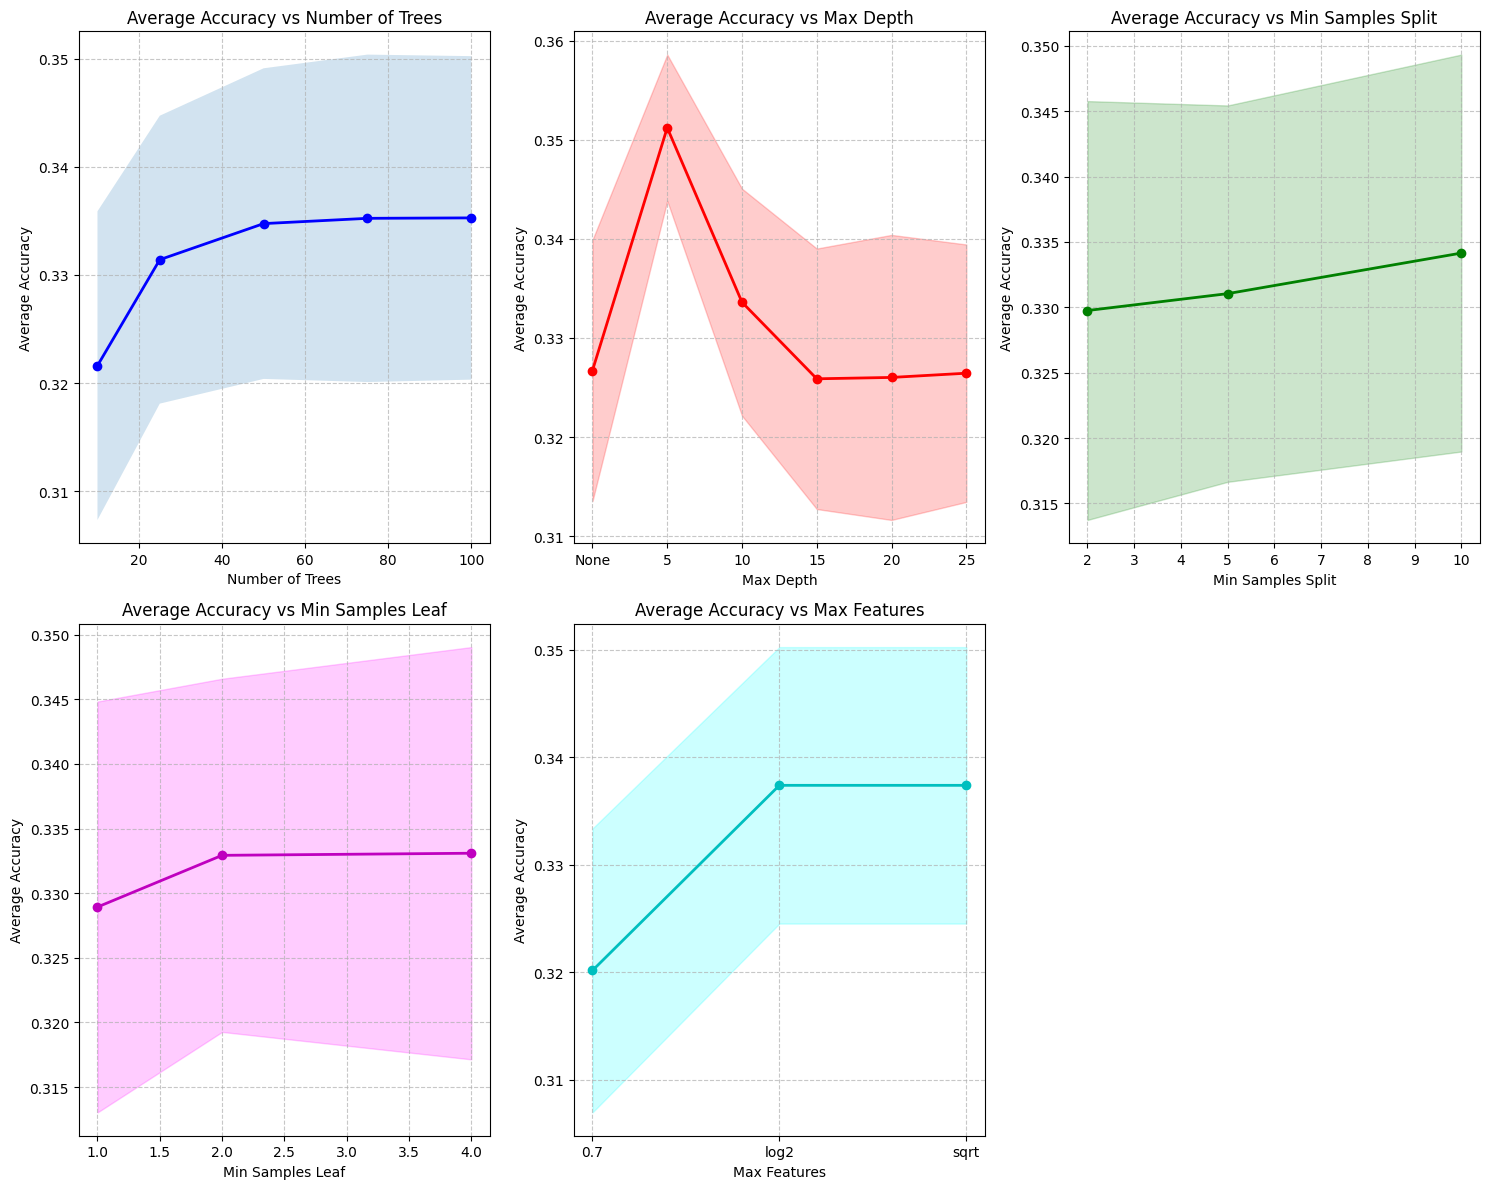


Summary of Parameter Performance:

Performance by Number of Trees:
           mean     std
n_trees                
10       0.3216  0.0143
25       0.3314  0.0133
50       0.3347  0.0144
75       0.3352  0.0151
100      0.3353  0.0150

Performance by Max Depth:
         mean     std
depth                
None   0.3267  0.0132
10     0.3336  0.0115
15     0.3259  0.0131
20     0.3260  0.0144
25     0.3264  0.0130
5      0.3512  0.0074

Top 5 Best Parameter Combinations:

Configuration:
Trees: 75
Max Depth: 5
Min Samples Split: 10
Min Samples Leaf: 1
Max Features: sqrt
Accuracy: 0.3640 (±0.0167)

Configuration:
Trees: 75
Max Depth: 5
Min Samples Split: 10
Min Samples Leaf: 1
Max Features: log2
Accuracy: 0.3640 (±0.0167)

Configuration:
Trees: 100
Max Depth: 5
Min Samples Split: 10
Min Samples Leaf: 4
Max Features: sqrt
Accuracy: 0.3624 (±0.0119)

Configuration:
Trees: 100
Max Depth: 5
Min Samples Split: 10
Min Samples Leaf: 4
Max Features: log2
Accuracy: 0.3624 (±0.0119)

Configuration:

/home/aniketh/.pyenv/versions/3.8.8/envs/crustdata-3.8.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aniketh/.pyenv/versions/3.8.8/envs/crustdata-3.8.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aniketh/.pyenv/versions/3.8.8/envs/crustdata-3.8.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

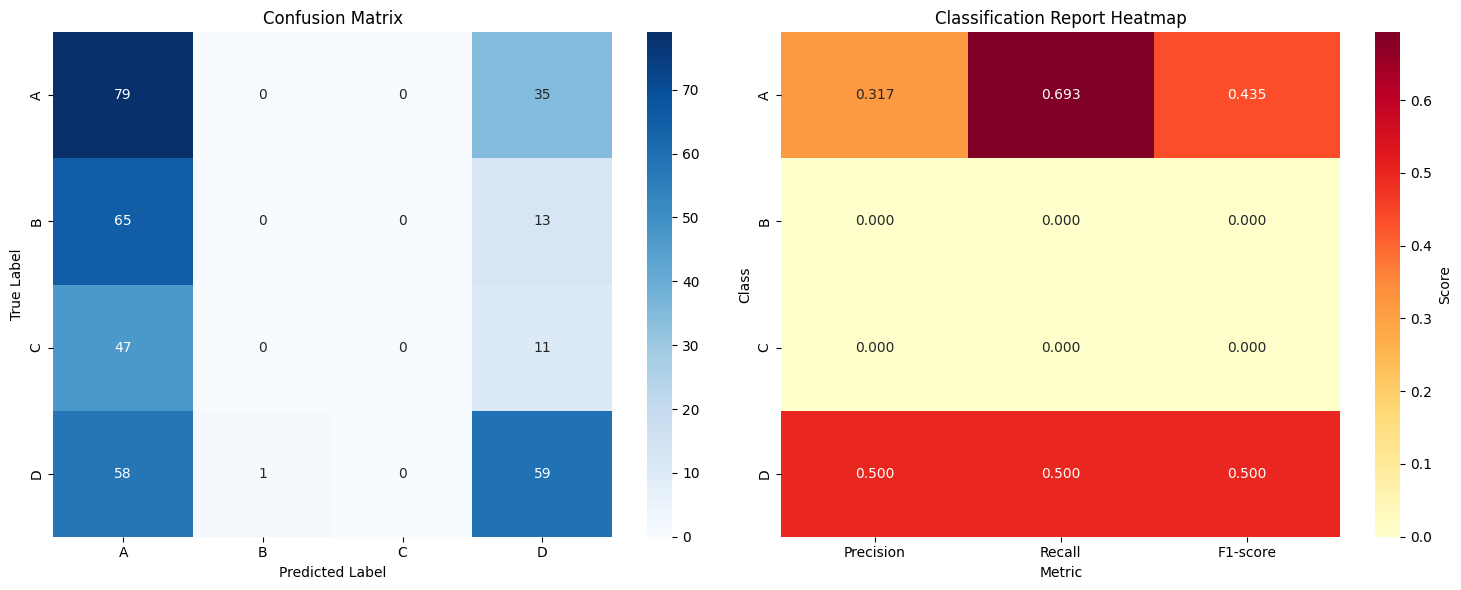


Predictions on validation dataset:
['A' 'A' 'A' 'D' 'A' 'A' 'D' 'A' 'A' 'A' 'A' 'A' 'A' 'D' 'A' 'A' 'A' 'A'
 'D' 'A' 'D' 'D' 'A' 'D' 'A' 'A' 'A' 'A' 'A' 'A' 'D' 'D' 'A' 'D' 'A' 'A'
 'A' 'A' 'D' 'D' 'D' 'A' 'A' 'A' 'A' 'A' 'D' 'A' 'A' 'A' 'A' 'D' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'D' 'A' 'A' 'A' 'A' 'A' 'D' 'A' 'D'
 'A' 'A' 'A' 'D' 'D' 'A' 'D' 'A' 'A' 'A' 'D' 'A' 'D' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'D' 'A' 'D' 'A' 'A' 'A' 'A' 'A' 'D' 'A' 'A' 'D' 'A' 'A' 'A' 'D'
 'D' 'A' 'A' 'A' 'A' 'D' 'D' 'A' 'A' 'A' 'A' 'A' 'A' 'D' 'D' 'D' 'D' 'D'
 'A' 'A' 'A' 'D' 'A' 'D' 'A' 'A' 'D' 'D' 'D' 'A' 'A' 'A' 'A' 'A' 'D' 'D'
 'D' 'A' 'A' 'A' 'D' 'A' 'A' 'D' 'A' 'D' 'A' 'A' 'A' 'A' 'D' 'A' 'D' 'A'
 'A' 'A' 'A' 'D' 'A' 'D' 'D' 'A' 'A' 'D' 'A' 'A' 'A' 'D' 'D' 'D' 'A' 'A'
 'D' 'A' 'A' 'B' 'A' 'D' 'D' 'D' 'D' 'D' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'D' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'D'
 'A' 'A' 'A' 'A' 'A' 'A' 'D' 'A' 'D' 'A' 'A' 'A' 'D' 'A' 'A' 'D' 'A' 'A'
 'D' 'D' 'A' 'A

In [35]:
def cross_validate_rf(X, y, rf_params, n_folds=5):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        rf = RandomForestClassifier(**rf_params)
        rf.fit(X_train_fold, y_train_fold)
        val_predictions = rf.predict(X_val_fold)
        score = accuracy_score(y_val_fold, val_predictions)
        scores.append(score)
    
    return np.mean(scores), np.std(scores)

def prepare_data(processed_train_data, processed_test_data):
    X_train_copy = processed_train_data.copy()
    y_train = processed_train_data["Segmentation"].values
    X_train = X_train_copy.drop("Segmentation", axis=1).values
    X_test = processed_test_data.values
    
    return X_train, y_train, X_test

def plot_parameter_performance(results_dict):
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    
    plt.figure(figsize=(15, 12))
    
    # Plot 1: Accuracy vs Number of Trees
    plt.subplot(2, 3, 1)
    tree_performance = results_df.groupby('n_trees')['accuracy'].mean()
    plt.plot(tree_performance.index, tree_performance.values, 'bo-', linewidth=2)
    plt.fill_between(tree_performance.index, 
                     tree_performance.values - results_df.groupby('n_trees')['accuracy'].std(),
                     tree_performance.values + results_df.groupby('n_trees')['accuracy'].std(),
                     alpha=0.2)
    plt.title('Average Accuracy vs Number of Trees', fontsize=12)
    plt.xlabel('Number of Trees', fontsize=10)
    plt.ylabel('Average Accuracy', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 2: Accuracy vs Max Depth
    plt.subplot(2, 3, 2)
    depth_data = results_df.copy()
    depth_order = ['None'] + [str(x) for x in sorted([int(d) for d in depth_data['depth'].unique() if d != 'None'])]
    
    depth_stats = []
    for depth in depth_order:
        mask = depth_data['depth'] == depth
        depth_stats.append({
            'depth': depth,
            'mean': depth_data[mask]['accuracy'].mean(),
            'std': depth_data[mask]['accuracy'].std()
        })
    
    depth_stats_df = pd.DataFrame(depth_stats)
    x_positions = range(len(depth_order))
    plt.plot(x_positions, depth_stats_df['mean'], 'ro-', linewidth=2)
    plt.fill_between(x_positions,
                     depth_stats_df['mean'] - depth_stats_df['std'],
                     depth_stats_df['mean'] + depth_stats_df['std'],
                     alpha=0.2, color='red')
    plt.xticks(x_positions, depth_order)
    plt.title('Average Accuracy vs Max Depth', fontsize=12)
    plt.xlabel('Max Depth', fontsize=10)
    plt.ylabel('Average Accuracy', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 3: Accuracy vs Min Samples Split
    plt.subplot(2, 3, 3)
    split_performance = results_df.groupby('min_samples_split')['accuracy'].agg(['mean', 'std'])
    plt.plot(split_performance.index, split_performance['mean'], 'go-', linewidth=2)
    plt.fill_between(split_performance.index,
                     split_performance['mean'] - split_performance['std'],
                     split_performance['mean'] + split_performance['std'],
                     alpha=0.2, color='green')
    plt.title('Average Accuracy vs Min Samples Split', fontsize=12)
    plt.xlabel('Min Samples Split', fontsize=10)
    plt.ylabel('Average Accuracy', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 4: Accuracy vs Min Samples Leaf
    plt.subplot(2, 3, 4)
    leaf_performance = results_df.groupby('min_samples_leaf')['accuracy'].agg(['mean', 'std'])
    plt.plot(leaf_performance.index, leaf_performance['mean'], 'mo-', linewidth=2)
    plt.fill_between(leaf_performance.index,
                     leaf_performance['mean'] - leaf_performance['std'],
                     leaf_performance['mean'] + leaf_performance['std'],
                     alpha=0.2, color='magenta')
    plt.title('Average Accuracy vs Min Samples Leaf', fontsize=12)
    plt.xlabel('Min Samples Leaf', fontsize=10)
    plt.ylabel('Average Accuracy', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 5: Accuracy vs Max Features
    plt.subplot(2, 3, 5)
    features_performance = results_df.groupby('max_features')['accuracy'].agg(['mean', 'std'])
    x_positions = range(len(features_performance.index))
    plt.plot(x_positions, features_performance['mean'], 'co-', linewidth=2)
    plt.fill_between(x_positions,
                     features_performance['mean'] - features_performance['std'],
                     features_performance['mean'] + features_performance['std'],
                     alpha=0.2, color='cyan')
    plt.xticks(x_positions, features_performance.index)
    plt.title('Average Accuracy vs Max Features', fontsize=12)
    plt.xlabel('Max Features', fontsize=10)
    plt.ylabel('Average Accuracy', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics (rest of the code remains same)
    print("\nSummary of Parameter Performance:")
    print("\nPerformance by Number of Trees:")
    tree_stats = results_df.groupby('n_trees')['accuracy'].agg(['mean', 'std']).round(4)
    print(tree_stats)
    
    print("\nPerformance by Max Depth:")
    depth_stats = results_df.groupby('depth')['accuracy'].agg(['mean', 'std']).round(4)
    print(depth_stats.reindex(['None'] + list(depth_stats.index.drop('None'))))
    
    print("\nTop 5 Best Parameter Combinations:")
    top_5 = results_df.nlargest(5, 'accuracy')
    for idx, row in top_5.iterrows():
        print(f"\nConfiguration:")
        print(f"Trees: {row['n_trees']}")
        print(f"Max Depth: {row['depth']}")
        print(f"Min Samples Split: {row['min_samples_split']}")
        print(f"Min Samples Leaf: {row['min_samples_leaf']}")
        print(f"Max Features: {row['max_features']}")
        print(f"Accuracy: {row['accuracy']:.4f} (±{row['std']:.4f})")

def grid_search_cv(X_train, y_train, param_grid):
    best_score = 0
    best_params = None
    results = {}
    
    for n_trees in param_grid['n_trees']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    for max_features in param_grid['max_features']:
                        params = {
                            'n_trees': n_trees,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'max_features': max_features,
                            'random_state': 42
                        }
                        
                        print(f"\nTesting parameters: {params}")
                        mean_score, std_score = cross_validate_rf(X_train, y_train, params)
                        
                        key = f"trees_{n_trees}_depth_{max_depth}_split_{min_samples_split}_leaf_{min_samples_leaf}_features_{max_features}"
                        results[key] = {
                            'accuracy': mean_score,
                            'std': std_score,
                            'n_trees': n_trees,
                            'depth': str(max_depth),
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'max_features': max_features
                        }
                        
                        if mean_score > best_score:
                            best_score = mean_score
                            best_params = params
                            print(f"New best score: {best_score:.4f} (±{std_score:.4f})")
                            print(f"Best parameters so far: {params}")
    
    return best_params, results

def train_and_evaluate(X_train, y_train, X_test, best_params):
    """Train model and evaluate with detailed metrics and visualizations."""
    final_rf = RandomForestClassifier(**best_params)
    final_rf.fit(X_train, y_train)
    
    test_predictions = final_rf.predict(X_test)
    
    # Split and evaluate on validation set
    X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    final_rf.fit(X_train_final, y_train_final)
    val_predictions_final = final_rf.predict(X_val_final)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val_final, val_predictions_final)
    cm = confusion_matrix(y_val_final, val_predictions_final)
    classes = np.unique(y_train)
    
    # Print detailed metrics
    print("\nFinal Validation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\nDetailed Metrics Report:")
    metrics_report = classification_report(y_val_final, val_predictions_final)
    print(metrics_report)
    
    # Print confusion matrix with class labels
    print("\nConfusion Matrix:")
    print("Predicted classes:")
    print("            " + " ".join(f"{c:>8}" for c in classes))
    print("True classes:")
    for i, class_name in enumerate(classes):
        print(f"{class_name:>11} {' '.join(f'{x:>8}' for x in cm[i])}")

    # Per-class metrics
    print("\nPer-class Performance:")
    for i, class_name in enumerate(classes):
        class_correct = cm[i][i]
        class_total = np.sum(cm[i])
        precision = class_correct / np.sum(cm[:, i]) if np.sum(cm[:, i]) > 0 else 0
        recall = class_correct / class_total if class_total > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_correct/class_total:.4f} ({class_correct}/{class_total})")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")

    # Create visualizations
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Plot 2: Classification Report Heatmap
    plt.subplot(1, 2, 2)
    # Get classification report as dictionary
    report = classification_report(y_val_final, val_predictions_final, output_dict=True)
    
    # Extract metrics for each class
    metrics_data = []
    for class_name in classes:
        if class_name in report:
            metrics_data.append({
                'Class': class_name,
                'Precision': report[class_name]['precision'],
                'Recall': report[class_name]['recall'],
                'F1-score': report[class_name]['f1-score']
            })
    
    # Create DataFrame for plotting
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df = metrics_df.set_index('Class')
    
    # Create heatmap
    sns.heatmap(metrics_df, annot=True, cmap='YlOrRd', fmt='.3f', 
                cbar_kws={'label': 'Score'})
    plt.title('Classification Report Heatmap')
    plt.ylabel('Class')
    plt.xlabel('Metric')
    
    plt.tight_layout()
    plt.show()
    
    print("\nPredictions on validation dataset:")
    print(val_predictions_final)
    
    return test_predictions, final_rf

def get_predictions(param_grid):    
    X_train, y_train, X_test = prepare_data(processed_train_data, processed_test_data)
    best_params, results = grid_search_cv(X_train, y_train, param_grid)
    
    plot_parameter_performance(results)
    
    test_predictions, final_model = train_and_evaluate(X_train, y_train, X_test, best_params)
    
    # Note: Total records are being truncated, saving to file
    predictions_df = pd.DataFrame(test_predictions, columns=['Segmentation'])
    predictions_df.to_csv('random_forest_predictions.csv', index=False)
    print("\nPredictions saved to 'random_forest_predictions.csv'")


param_grid = {
    'n_trees': [10, 25, 50, 75, 100],
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.7]
}

get_predictions(param_grid=param_grid)